---
### **Welcome to the [Stock / Portfolio Required Return Analysis Notebook (Part 1)]!**  
This is part [1] of a 3-part series. If you haven't already, please start with the [`data_cleaning_formatting.ipynb`](https://github.com/andylhyl/FinModelPortfolioSimulator/blob/main/data_cleaning_formatting.ipynb) notebook to understand the data preprocessing steps.

---

# Stock / Portfolio Required Return Analysis Notebook (Part 1)
.Building on the previous notebooks, this notebook dives into the simulation of financial models. The core objectives are:
- Evaluating stock performance using various financial models.
- Comparing predicted returns across different models.
- Analyzing how each model interprets stock data and market conditions.

Let's get s by setting up the environment and importing the necessary data.

### Library Imports and Initial Setup

Import all required libraries and establish initial data for data analysis and visualization.

In [1]:
import requests
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.optimize as sco

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from project_functions import get_beta 

In [4]:
%run data_cleaning_formatting.ipynb

Enter 'short' or 'long' for the time interval you want to analyse data for(or press Enter to use the default): 
You have selected: short
Enter the stock ticker for stock (or press Enter to use the default) 1: 
you have choosed the default stock list
You have choosed the following stock tickers: AAPL, ORCL, NVDA


In [5]:
# Note: here we make sure that all analysis is done on stock's data, not including market index:
list_copy = list_copy[0:3]

# Model 1: CAPM (Capital Asset Pricing Model)

$$ E(R_i) = R_f + \beta_i (E(R_m) - R_f) $$




- CAPM is a financial model used to determine the expected return on an asset based on its systematic risk (beta). It asserts that the only compensation for bearing risk is the risk associated with the overall market, not individual securities. 



- In essence, CAPM calculates the return an investor should expect to receive on an asset given its risk relative to the market.


### Stockwise expected return:

In [6]:
# Finding the expected stocks return under CAPM:

return_list = {}

ave_rf = final_data['rf'].mean()
beta_dict = get_beta('capm', final_data, list_copy)
ave_mkt = final_data['mkt_ex_return'].mean()

for i in list_copy:
    beta = beta_dict[i]['mkt_ex_return']
    expected_return = ave_rf + beta * (ave_mkt)
    return_list[i] = expected_return

In [7]:
return_list

{'AAPL': 0.003941674391109033,
 'ORCL': -0.015051819391131843,
 'NVDA': -0.05895973425377142}

### Equally Weighted Portfolio expected return:

In [8]:
port_return1 = sum(return_list.values()) / len(return_list)
port_return1

-0.023356626417931414

# Model 2: Fama-French Three-Factor Model:

$$ R_i - R_f = \alpha + \beta_m (R_m - R_f) + \beta_s \times SMB + \beta_v \times HML + \epsilon $$


- Building on the CAPM, Eugene Fama and Kenneth French introduced a three-factor model to better explain stock returns. They posited that two additional factors, size and value, can predict stock returns better than market risk alone.

### Stockwise expected return:

In [9]:
# Finding the expected stocks return under Fama-French's model:

return_list2 = {}

beta_dict = get_beta('fama', final_data, list_copy)
ave_HML = final_data['HML'].mean()
ave_SMB = final_data['SMB'].mean()

for i in list_copy:
    beta_mkt = beta_dict[i]['mkt_ex_return']
    beta_hml = beta_dict[i]['HML']
    beta_smb = beta_dict[i]['SMB']

    expected_return = ave_rf + beta_mkt * (ave_mkt) + beta_hml * ave_HML + beta_smb * ave_SMB
    return_list2[i] = expected_return
    

In [10]:
return_list2

{'AAPL': 0.00512364835074055,
 'ORCL': -0.01730486874728882,
 'NVDA': -0.06325069106474561}

### Equally Weighted Portfolio expected return:

In [11]:
port_return2 = sum(return_list2.values()) / len(return_list2)
port_return2

-0.02514397048709796

# Model 3: Momentum Factor Model:
$$
\text{Expected Return} = \alpha + \beta_{\text{Mkt}}(\text{Mkt-RF}) + \beta_{\text{SMB}}(\text{SMB}) + \beta_{\text{HML}}(\text{HML}) + \beta_{\text{Mom}}(\text{Mom}) + \epsilon
$$


- Momentum, as a factor, builds on the idea that stocks which have performed well in the past tend to continue performing well, and vice versa. The momentum factor model adds a momentum factor on top of the original Fama-French Three-Factor Model.

### Stockwise expected return:

In [12]:
# Finding the expected stocks return under Momentum model:

return_list3 = {}

beta_dict = get_beta('momentum', final_data, list_copy)
ave_HML = final_data['HML'].mean()
ave_SMB = final_data['SMB'].mean()
ave_Mom = final_data['Mom'].mean()

for i in list_copy:
    beta_mkt = beta_dict[i]['mkt_ex_return']
    beta_hml = beta_dict[i]['HML']
    beta_smb = beta_dict[i]['SMB']
    beta_mom = beta_dict[i]['Mom']
    
    expected_return = ave_rf + beta_mkt * (ave_mkt) + beta_hml * ave_HML + beta_smb * ave_SMB + beta_mom * ave_Mom
    return_list3[i] = expected_return

In [13]:
return_list3

{'AAPL': 0.004504944283780097,
 'ORCL': -0.02040018237267989,
 'NVDA': -0.0762925835635979}

### Equally Weighted Portfolio expected return:

In [14]:
port_return3 = sum(return_list3.values()) / len(return_list3)
port_return3

-0.030729273884165898

# Plots And Discussion:

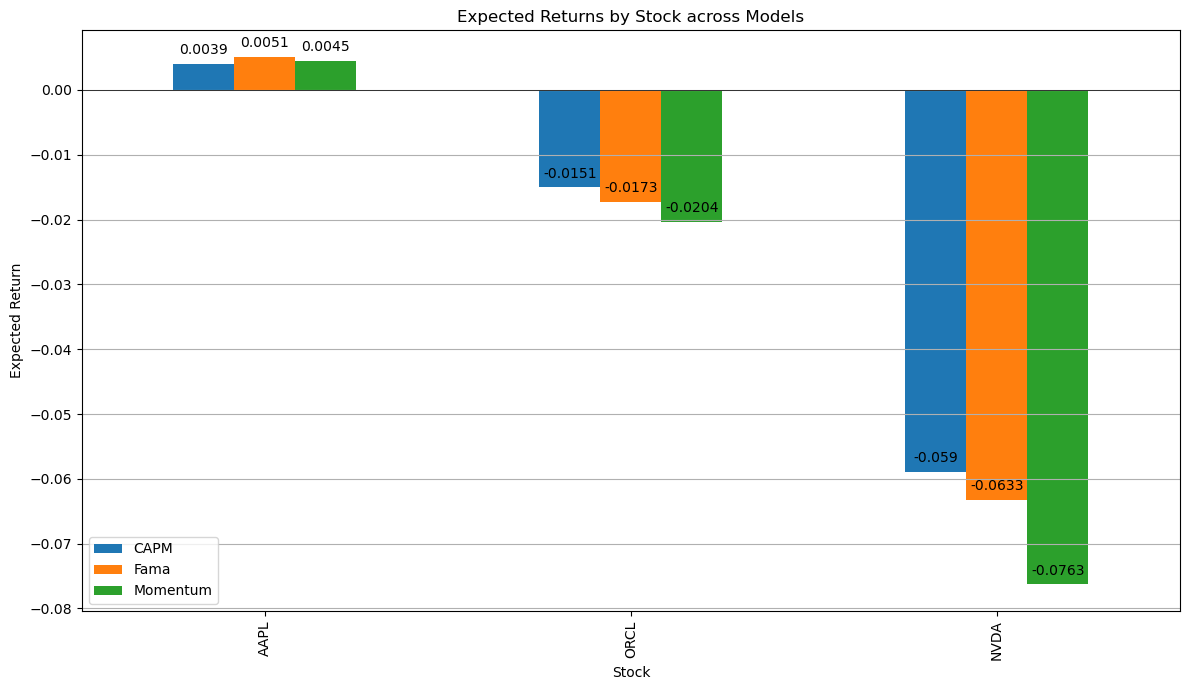

In [15]:
# Grouping by stocks:
df_capm = pd.DataFrame(list(return_list.items()), columns=['Stock', 'CAPM'])
df_fama = pd.DataFrame(list(return_list2.items()), columns=['Stock', 'Fama'])
df_momentum = pd.DataFrame(list(return_list3.items()), columns=['Stock', 'Momentum'])

# Build a dataframe that have stocks return seperated under different models:
ret_data = df_capm.merge(df_fama, on='Stock').merge(df_momentum, on='Stock')

# Creating the plot:
ax = ret_data.plot(x='Stock', y=['CAPM', 'Fama', 'Momentum'], kind='bar', figsize=(12,7))
plt.title('Expected Returns by Stock across Models')
plt.ylabel('Expected Return')
plt.xlabel('Stock')
plt.axhline(0, color='black',linewidth=0.5)
plt.grid(axis='y')

# Adding numeric values on top of each data bar:
for p in ax.patches:
    # For each bar, we want the value to be at the top middle portion of the bar:
    ax.annotate(str(round(p.get_height(), 4)), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.tight_layout()
plt.show()



### **General Analysis:**

- **Model Variances by Stock**:  
While some stocks can exhibit close expected returns, indicating relative consensus among the models, others can also present a broader range, indicating significant divergence in predictions.

- **Consensus and Contention**:  
For stocks where the models converge in their predictions, there might be a higher degree of confidence in those expected returns. In contrast, stocks with wide variations across models spotlight areas of contention, possibly stemming from differing views on market risk, stock value, or recent performance trends.

- **Dominant Models**:  
If one model consistently forecasts higher or lower returns across most stocks, it could indicate a systematic bias in that model, reflecting a more optimistic or conservative outlook.

### **Discussion:**

- **Model Foundations**:  
The differences in expected returns for individual stocks across models emphasize the significance of understanding each model's basis. Recognizing the distinctions in models, from the market-relationship focus of CAPM to Fama's emphasis on company size and value and the Momentum model's look at recent trends, is crucial. With that, we can see why the momentum model present a rather extreme result, in contrast to the other two models predicting a very close expected return.

- **Investment Implications**:  
These insights can shape investment strategies. A stock with similar expected returns across models might be viewed as a more reliable bet, while stocks with significant model differences might warrant deeper investigation.

- **Risk Considerations**:  
The range of expected returns for each stock can also be interpreted as a measure of prediction risk, with a narrower range indicating lower risk and a broader range suggesting higher uncertainty.

### **Conclusion:**

The analysis for the expected return can possibly offers a comprehensive view on the stock returns itself. By using the predictions from CAPM, Fama's model, and the Momentum model, investor can see that result as a benchmark return for their own investment. However, even though these models can potentially provide valuable guidance based on historical data and theoretical constructs, one may not forget to use a balanced approach, factoring in both model predictions and other analyses, to ensures a well-rounded investment strategy.



---
### **Thank you for exploring this part!**  
Dive deeper into portfolio optimization strategies in [`Fin model simulator (Part 2).ipynb`](https://github.com/andylhyl/FinModelPortfolioSimulator/blob/main/Fin%20model%20simulator%20(Part%202%EF%BC%89.ipynb).


---